# Customer Segmentation

In [12]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df_c_train_fe = pd.read_pickle('data/df_c_train_fe.pkl')
df_customers = pd.read_csv('data/customers.csv')

In [14]:
# drop NA values and non-useful columns
cleaned_customers_df = df_customers.dropna(
    subset=["customer_id", "postal_code", "age", "fashion_news_frequency", "club_member_status"]).drop(columns=["FN", "postal_code", "club_member_status", "Active"])

# change "NONE" and "nan" values to "None"
cleaned_customers_df["fashion_news_frequency"] = df_customers["fashion_news_frequency"].replace({"NONE": "None", "None": "None"})

In [15]:
# merge df_c_train_fe with cleaned_customers_df to get age
df_c_train_fe = pd.merge(cleaned_customers_df, df_c_train_fe, on='customer_id', how='inner')

In [16]:
print("Head of df_c_train_fe:")
df_c_train_fe.head()

Head of df_c_train_fe:


,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",11 days 12:00:00,276.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",3 days 10:06:18.947368421,82.0
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.26786265, 0.3283508, -0.06105471, 0.118410...",0 days 00:00:00,8760.0
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.205381, -0.26421732, 0.22735098, -0.1606186...",0 days 00:00:00,8760.0
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",1 days 21:31:02.068965517,46.0


In [17]:
norm_unique_values_counts = df_c_train_fe['hours_between_purchases'].value_counts()
print(norm_unique_values_counts)

hours_between_purchases
8760.0    237556
24.0        5016
48.0        4359
72.0        3986
96.0        3445
           ...  
592.0         11
1632.0        10
1728.0         7
1776.0         4
1752.0         4
Name: count, Length: 384, dtype: int64


### Differentiating hours_between_purchases via quartiles
1. Exclude "no_repurchase_hours" first
2. Plot Histogram to observe distribution
3. Obtain quantiles
4. Categorise respectively into "Very Short", "Short", "Medium", "Long", "Very Long", "Never"

In [18]:
from sklearn.preprocessing import MinMaxScaler

# exclude "Never", in context of not repurchasing
df_for_scaling = df_c_train_fe[df_c_train_fe['hours_between_purchases'] != 8760.0].copy()

# Min-Max Scale to preserve the shape of the dataset's distribution but does not reduce the importance of outliers.
scaler = MinMaxScaler()
df_for_scaling['hours_between_purchases_scaled'] = scaler.fit_transform(df_for_scaling[['hours_between_purchases']])

# merge the scaled values back into the original DataFrame
df_c_train_fe = df_c_train_fe.merge(df_for_scaling[['hours_between_purchases_scaled']], left_index=True, right_index=True, how='left')

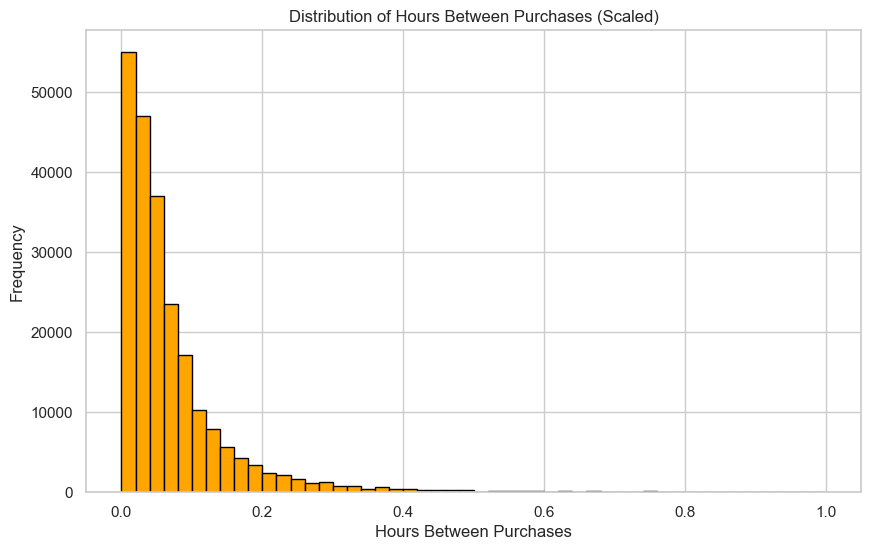

In [19]:
# plot histogram to see distribution
sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6)) 
plt.hist(df_for_scaling['hours_between_purchases_scaled'], bins=50, color='orange', edgecolor='black') 

plt.title('Distribution of Hours Between Purchases (Scaled)')
plt.xlabel('Hours Between Purchases')
plt.ylabel('Frequency')

plt.show()

In [20]:
# Calculate 5 Quantiles (20th, 40th, 60th, 80th percentiles)
quantiles = df_for_scaling['hours_between_purchases_scaled'].quantile([0.25, 0.50, 0.75]).to_list()

# Print the calculated boundaries
print(f"Quartile Boundaries: {quantiles}")

Quartile Boundaries: [0.020845070422535212, 0.04450704225352113, 0.08732394366197183]


In [21]:
# converts numerical hours to categories
def categorise_hours(scaled_hours):
    if pd.isna(scaled_hours):  # This will catch the 8760 values which are NaN in 'hours_between_purchases_scaled'
        return "Never"
    elif scaled_hours <= quantiles[0]:
        return "Short"
    elif scaled_hours <= quantiles[1]:
        return "Medium"
    elif scaled_hours <= quantiles[2]:
        return "Long"

    return "Very Long"

# apply categorization
df_c_train_fe['purchase_behaviour'] = df_c_train_fe['hours_between_purchases_scaled'].apply(categorise_hours)

# check the distribution of categories
print(df_c_train_fe['purchase_behaviour'].value_counts())

purchase_behaviour
Never        237556
Short         57808
Long          56610
Medium        55888
Very Long     55877
Name: count, dtype: int64


## Multi-Feature Clustering
1. Customer Characteristics: `'age', 'fashion_news_frequency'`

`K-Prototypes` - an extension of K-Means that can handle both numerical and categorical data, making it suitable for this mix of data types. It combines the K-Means objective function for numerical data with the K-Modes objective function for categorical data, allowing it to effectively find clusters within mixed data types.

Pro: Specifically designed for clustering mixed data types.

2. Transactional Behaviour:  `'spending_power_encoded', 'purchase_behaviour_encoded'`

`K-Means` - clustering label_encoded. It means for clustering, which allows it to handle ordinal relationships via distance effectively by minimizing the dissimilarities between points in a cluster and maximizing the dissimilarities between different clusters.

Pro: Efficiently clusters data

### KPrototype for `'age', 'fashion_news_frequency'`
1. Find optimal number of clusters
2. Fit to training data
3. Plot a violin plot to visualise the relationships between two variables and the clusters

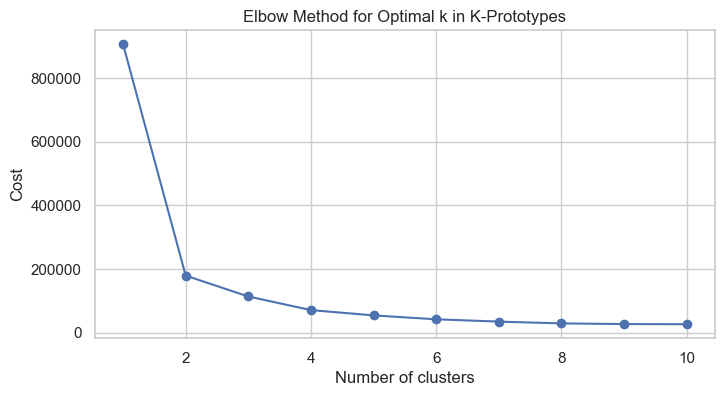

In [22]:
from kmodes.kprototypes import KPrototypes

# find optimal clusters for KProto
data = df_c_train_fe[['age', 'fashion_news_frequency']].copy()
data['fashion_news_frequency'] = data['fashion_news_frequency'].astype(str)

# random sample to improve run time
sampled_data = data.sample(frac=0.01, random_state=42)

costs = []
for k in range(1, 11):
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, max_iter=10, verbose=0)
    kproto.fit(sampled_data, categorical=[1])
    costs.append(kproto.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Prototypes')
plt.show()

In [23]:
# Fit KPrototypes on the full dataset
# From above, optimal number of clusters is 2
kproto_full = KPrototypes(n_clusters=2, n_init=5, max_iter=10, verbose=0)
clusters_kp_full = kproto_full.fit_predict(
    df_c_train_fe[['age', 'fashion_news_frequency']],
    categorical=[1]
)

# Assign the cluster labels to the full dataset
df_c_train_fe['Customer_Characteristics_Cluster'] = clusters_kp_full

### Violin Plot to show the distribution of ages for each cluster within each `fashion_news_frequency` category. This will give us insight into the `age` distribution for each cluster and category combination.

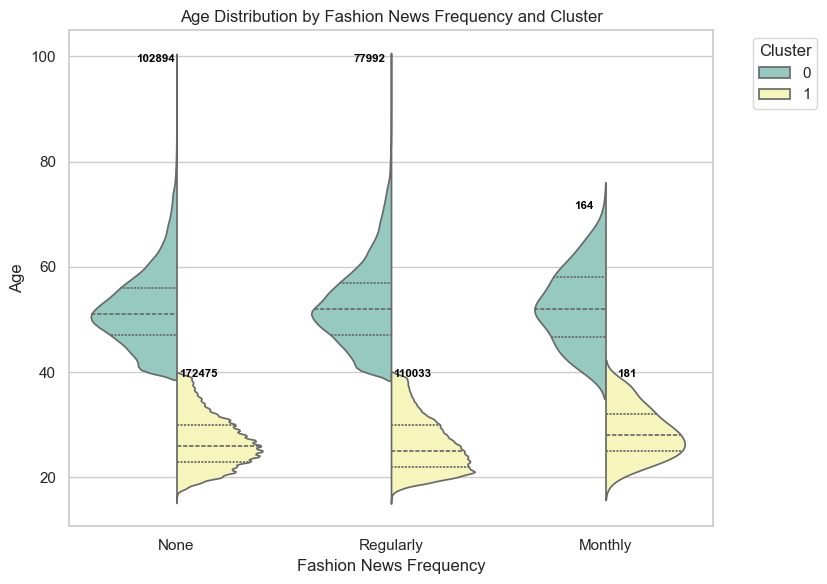

In [24]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

# violin plot
ax = sns.violinplot(x="fashion_news_frequency", y="age", hue="Customer_Characteristics_Cluster",
                    split=True, inner="quart", palette="Set3", data=df_c_train_fe)

# labels
plt.title('Age Distribution by Fashion News Frequency and Cluster')
plt.xlabel('Fashion News Frequency')
plt.ylabel('Age')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)

# adding frequency numbers inside the violin plot
# need to consider the hue "Customer_Characteristics_Cluster" when calculating positions
for i, group in enumerate(df_c_train_fe['fashion_news_frequency'].unique()):
    for j, cluster in enumerate(df_c_train_fe['Customer_Characteristics_Cluster'].unique()):
        position = ax.get_xticks()[i] + 0.2 * (j - 0.5)  
        subset = df_c_train_fe[(df_c_train_fe['fashion_news_frequency'] == group) &
                               (df_c_train_fe['Customer_Characteristics_Cluster'] == cluster)]
        num_observations = len(subset)
        ax.text(position, subset['age'].max(), num_observations, horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

### K-Means for `'spending_power_encoded', 'purchase_behaviour_encoded'`
do-before: convert categorical features into encoded labels, to preserve ordinal nature (e.g. Low, Medium, High to 0, 1, 2)
1. Find optimal number of clusters
2. Fit to training data
3. Plot a pivot table to visualise the relationships between two categorical variables and the clusters

In [27]:
# convert categorical features into encoded labels, to preserve ordinal nature
spending_power_map = {'Low': 0, 'Medium': 1, 'High': 2}
purchase_behaviour_map = {'Never': 4, 'Very Long': 3, 'Long': 2, 'Medium': 1, 'Short': 0}
df_c_train_fe['spending_power_encoded'] = df_c_train_fe['spending_power'].map(spending_power_map)
df_c_train_fe['purchase_behaviour_encoded'] = df_c_train_fe['purchase_behaviour'].map(purchase_behaviour_map)

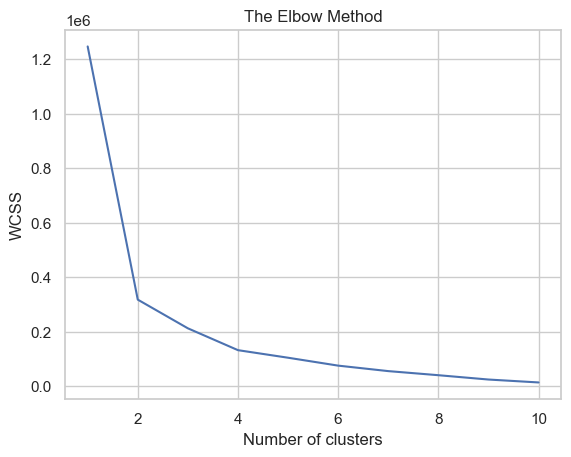

In [28]:
from sklearn.cluster import KMeans

# find optimal clusters for KModes
X = df_c_train_fe[['spending_power_encoded', 'purchase_behaviour_encoded']]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

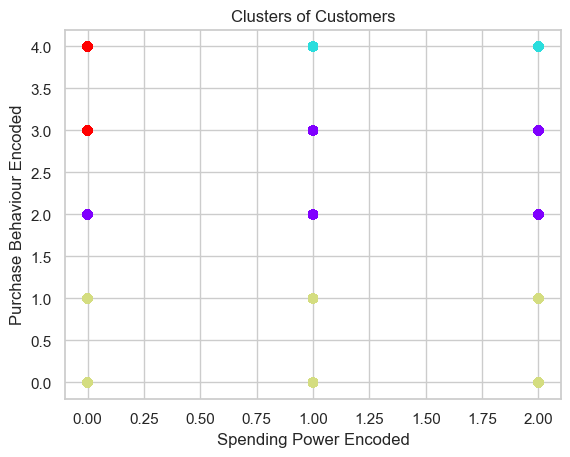

In [29]:
# 'elbow' point from above
k_optimal = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=500, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# add the cluster labels to df_c_train_fe
df_c_train_fe['Transactional_Behaviour_Cluster'] = cluster_labels

# visualize the clusters
plt.scatter(df_c_train_fe['spending_power_encoded'], df_c_train_fe['purchase_behaviour_encoded'], \
            c=df_c_train_fe['Transactional_Behaviour_Cluster'], cmap='rainbow')
plt.title('Clusters of Customers')
plt.xlabel('Spending Power Encoded')
plt.ylabel('Purchase Behaviour Encoded')
plt.show()

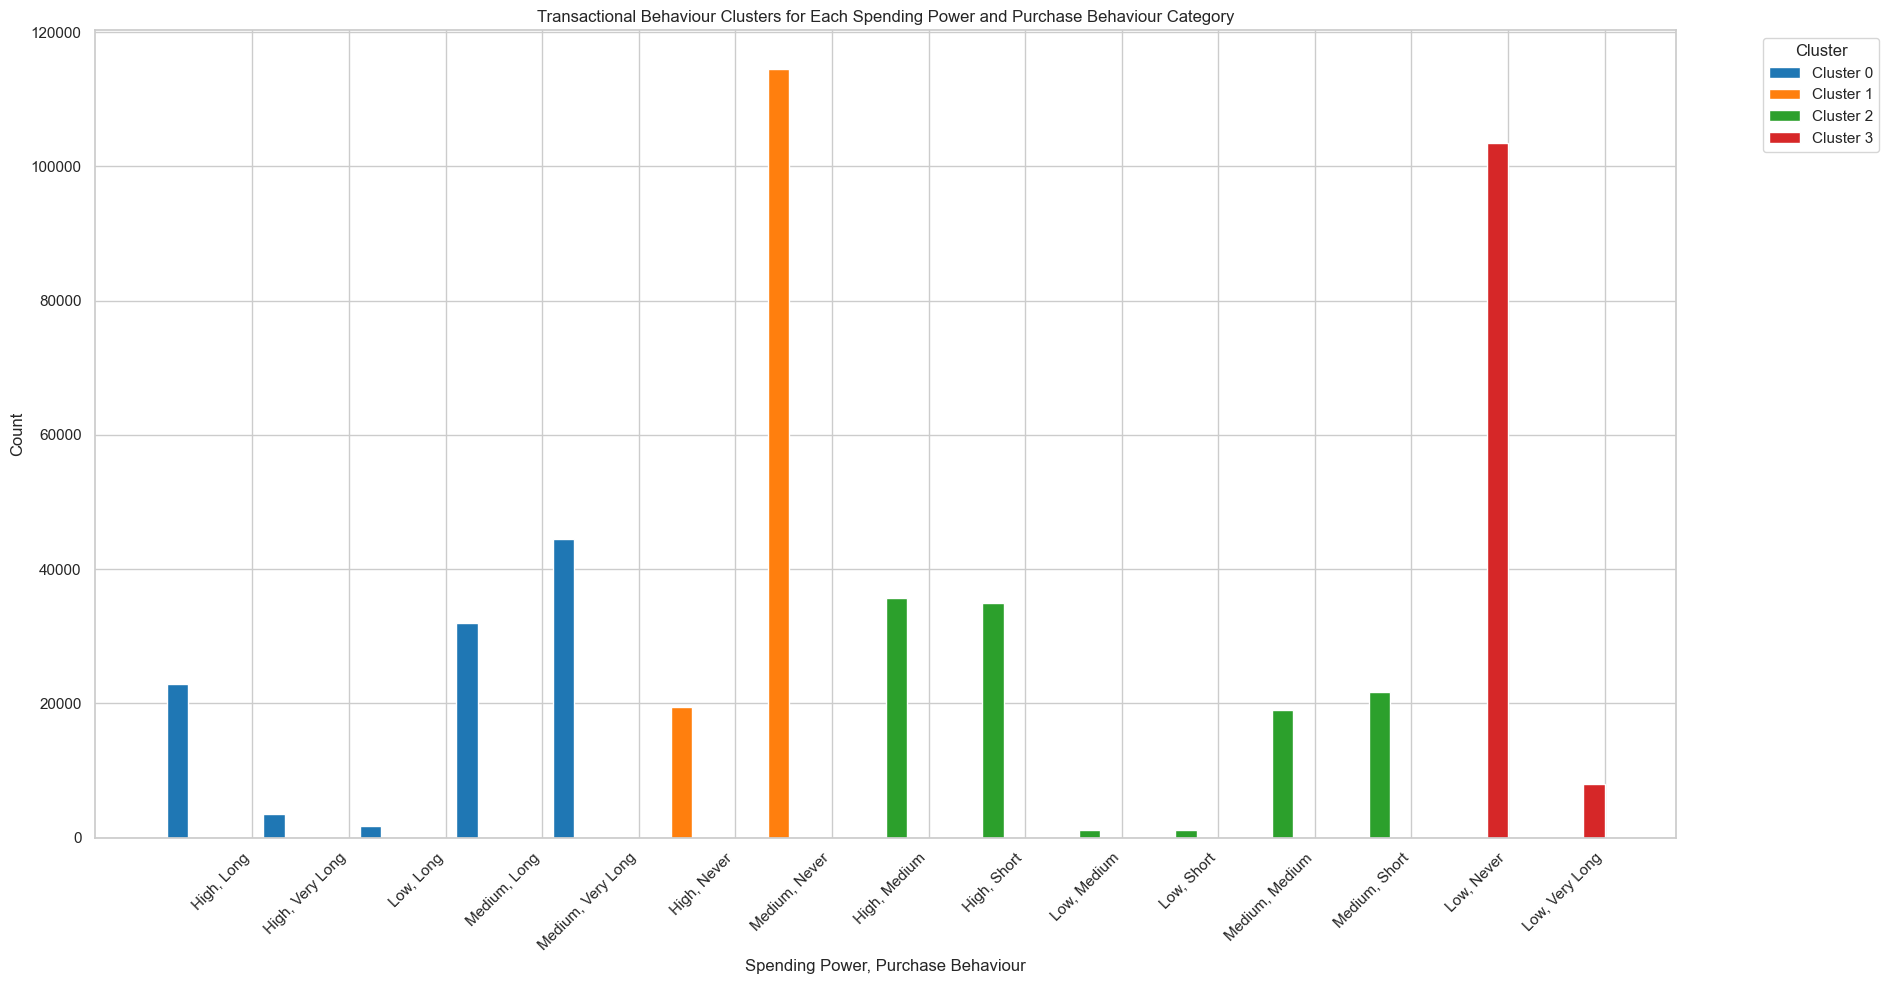

In [30]:
# aggregate and count occurrences for each combination
plot_data = df_c_train_fe.groupby(['Transactional_Behaviour_Cluster', 'spending_power', 'purchase_behaviour']).size().reset_index(name='count')

# sort the data by cluster for visualization
plot_data.sort_values(by='Transactional_Behaviour_Cluster', inplace=True)

# create the category tuples and extract the unique categories
plot_data['category'] = plot_data[['spending_power', 'purchase_behaviour']].apply(tuple, axis=1)
categories = plot_data['category'].unique()

plt.figure(figsize=(19, 10))

# num of clusters and categories
n_clusters = plot_data['Transactional_Behaviour_Cluster'].nunique()
n_categories = len(categories)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Assuming 4 clusters

# bar width and initial xticks_positions list
bar_width = 0.8
xticks_positions = []

# plot each cluster's bars
for cluster_num in range(n_clusters):
    cluster_data = plot_data[plot_data['Transactional_Behaviour_Cluster'] == cluster_num]
    
    # plot bars for each category
    for i, category in enumerate(categories):
        x_position = i * (n_clusters * (bar_width + 0.1)) + cluster_num * bar_width
        
        # append the position for the xticks
        if cluster_num == 0:
            xticks_positions.append(x_position)
        
        # get the count for the current category and cluster
        count = cluster_data[cluster_data['category'] == category]['count'].iloc[0] if not cluster_data[cluster_data['category'] == category].empty else 0
        
        plt.bar(x_position, count, width=bar_width, color=colors[cluster_num], label=f'Cluster {cluster_num}' if i == 0 else "")

# Adjust xticks_positions to align with the middle of the group
xticks_positions = [x + (n_clusters * bar_width) - bar_width / 2 for x in xticks_positions]

plt.xticks(xticks_positions, [', '.join(map(str, cat)) for cat in categories], rotation=45, ha='right')

plt.title('Transactional Behaviour Clusters for Each Spending Power and Purchase Behaviour Category')
plt.xlabel('Spending Power, Purchase Behaviour')
plt.ylabel('Count')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
df_c_train_fe["Customer_Characteristics_Cluster"] = df_c_train_fe['Customer_Characteristics_Cluster'].astype('uint16')

In [32]:
df_c_train_fe_final = df_c_train_fe.drop(columns=['spending_power_encoded', 'purchase_behaviour_encoded', 
                                                  'hours_between_purchases_scaled', 'total_spent', 'fashion_news_frequency',
                                                  'age', 'preferred_products', 'preferred_colors', 'preferred_perceived_colors',
                                                  'combined_preferences', 'combined_preferences_embeddings', 'hours_between_purchases',
                                                  'purchase_behaviour', 'avg_time_diff_btw_purchase', 'spending_power'])
df_c_train_fe_final.head(5)

,customer_id,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,1
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,1,3
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0,2


In [33]:
print(df_c_train_fe_final['Customer_Characteristics_Cluster'].value_counts())
print(df_c_train_fe_final['Transactional_Behaviour_Cluster'].value_counts())

Customer_Characteristics_Cluster
1    282689
0    181050
Name: count, dtype: int64
Transactional_Behaviour_Cluster
1    134029
2    113696
3    111443
0    104571
Name: count, dtype: int64


In [34]:
df_c_train_fe_final.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_train_cs.pkl'))